In [14]:
import os
import pdb
import numpy as np
import numpy.random as npr
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
import json
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rules_dict
from network import Model
import tools
from tools_lnd import make_FP_axs, plot_var_in
from tools_lnd import gen_X_from_model_dir_epoch, gen_trials_from_model_dir, gen_D_fp_qr,gen_mov_trial_set

In [15]:
# ##################################################################
# #fig save path
# ##################################################################

##CHANGE EPOCH_SET_MASTER TO GENERATE DIFF ROWS IN FIGURE
epoch_set_master = ['stim1','stim1']

fig_name = 'supp2'
figpath = os.path.join(p_code,'figs',fig_name,epoch_set_master[0])
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [16]:
# ##################################################################
# #Find right model dir
# ##################################################################
fig_name = 'fig2'
rule_trains = ['delaygo','delayanti']
ruleset = 'mem_motifs_small'
file = 'LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0'
m = os.path.join(p_data,fig_name,file)

In [17]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_75900/984896892.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys')


<Figure size 1000x500 with 0 Axes>

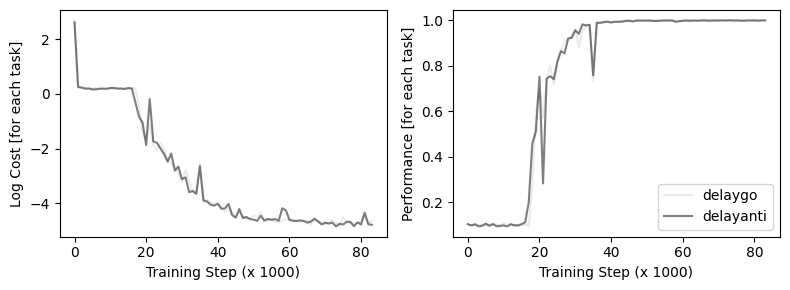

In [18]:
fig = plt.figure(figsize=(10, 5))
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Define a colormap
cmap = plt.cm.get_cmap('Greys')

# Plot cost and performance for each rule
for i, rule in enumerate(rule_trains):
    color = cmap(i+1 / (len(rule_trains) + 2))  # Normalize color index

    ax1.plot(np.log(log_all['cost_'+rule]), '-', color=color, alpha=0.5, label=rule)
    ax2.plot(log_all['perf_'+rule], '-', color=color, alpha=0.5, label=rule)

# Set axis labels and title
ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
# fig.suptitle(file)  # Set a common title for both subplots


# Add legend
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' sha

/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:432: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_trial[0,0],X_trial[0,1],X_trial[0,2],s = markersize,marker = 'x',


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2873: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2873: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2874: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout,

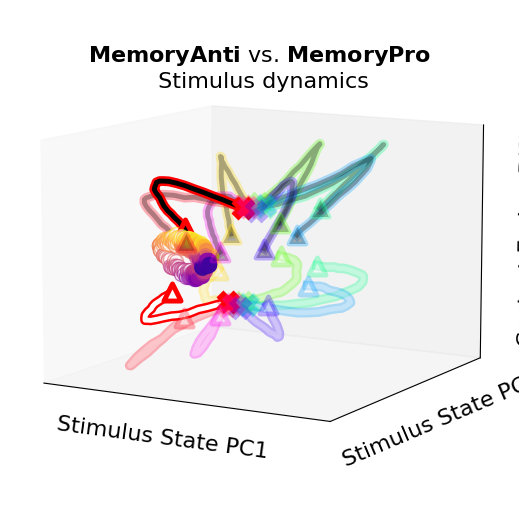

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


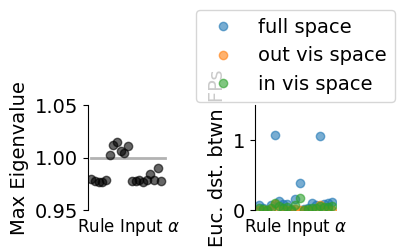

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

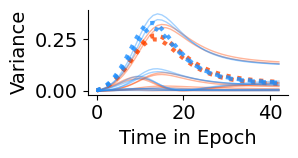

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' sha

/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:432: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_trial[0,0],X_trial[0,1],X_trial[0,2],s = markersize,marker = 'x',


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2873: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2873: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2874: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout,

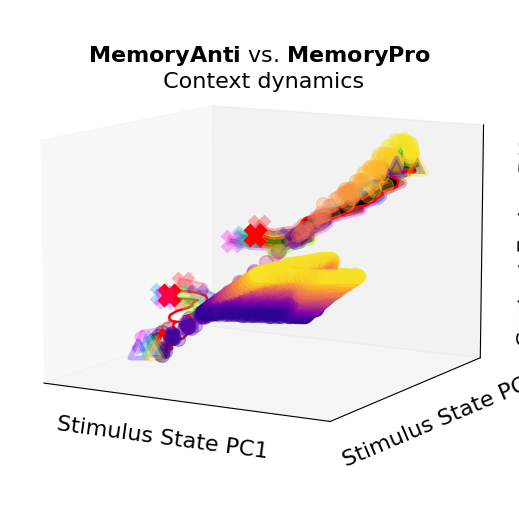

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


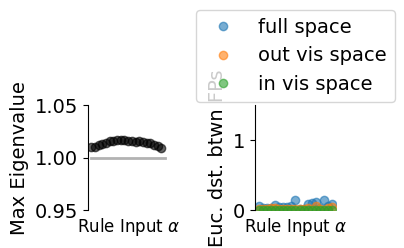

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

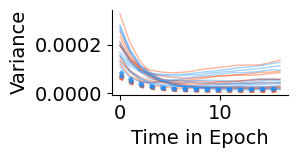

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' sha

/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:432: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_trial[0,0],X_trial[0,1],X_trial[0,2],s = markersize,marker = 'x',


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2873: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2873: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2874: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout,

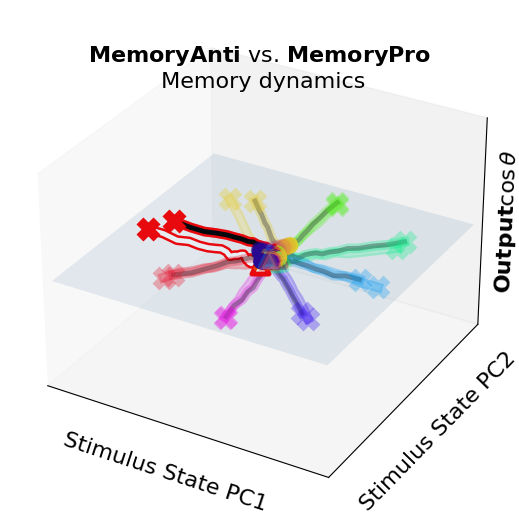

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


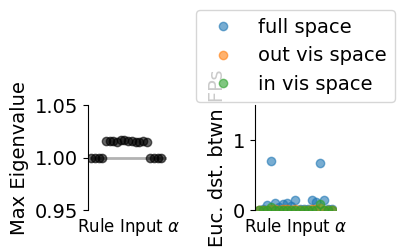

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

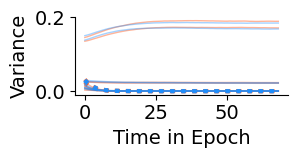

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

In [ ]:
from tools_lnd import interp3d, take_names, find_fp_dst_subspaces, plot_var_in

interp = True
fig_size = 5
linestyle = ['-','-']
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]

axs = 'pca_h_cat'

rule_set = [5,2]
rule_str = [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]
rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)

rule = rules_dict['all'][rule_set[rule_axs]]
D_stim = make_FP_axs(' ', m, rule_str, epoch_set_master, axs = axs)

D_use = D_stim
D_use[:,2] = D_fp_qr[:,0]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set_master[0],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [epoch_name_ax+' State PC1',
             epoch_name_ax+' State PC2',
             epoch_name_ax+' State PC3']

script_name = 'interp_tasks_small_init_stim'
epoch_set = ['stim1','stim1']
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .6,plot_zero_plane = False, 
         ax_labels = ax_labels, stability_thresh = 1, z_label = 'Context Endpt. Diff',view_ang = [10, -60])
_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)

plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs)

script_name = 'interp_tasks_small_init_mov'
epoch_set = ['fix1','fix1']
rule = rules_dict['all'][rule_set[rule_axs]]
# D_use = make_FP_axs(' ', m, rule_str, epoch_set[0], axs = axs)
# epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
# ax_labels = [epoch_name_ax+' State PC1',
#              epoch_name_ax+' State PC2',
#              epoch_name_ax+' State PC3']

D_use[:,2] = D_fp_qr[:,0]
q_thresh = .000001
epoch_set = ['fix1','fix1']

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .3,plot_zero_plane = False,n_trials = 8,
         ax_labels = ax_labels, stability_thresh = 1.05, z_label = 'Context Endpt. Diff',view_ang = [10, -60])
_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs)


epoch_set = ['delay1','delay1']
# D_use = make_FP_axs(' ', m, rule_str, epoch_set[0], axs = axs)
# epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
# ax_labels = [epoch_name_ax+' State PC1',
#              epoch_name_ax+' State PC2',
#              epoch_name_ax+' State PC3']

D_use[:,2] = w_out[:,2]
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True, view_ang = [30, -60],
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 1.05)
_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs)

epoch_set = ['go1','go1']
# D_use = make_FP_axs(' ', m, rule_str, epoch_set[0], axs = axs)
# epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
# ax_labels = [epoch_name_ax+' State PC1',
#              epoch_name_ax+' State PC2',
#              epoch_name_ax+' State PC3']

D_use[:,2] = w_out[:,2]
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True, view_ang = [10, -60],
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 2)
_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs)

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/tight_layout.py:177: UserWarning: The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The left and right margins cannot be made large '
/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/tight_layout.py:182: UserWarning: The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The bottom and top margins cannot be made large '


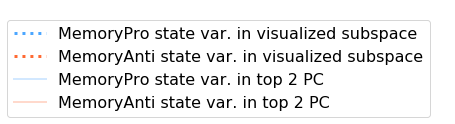

In [11]:
fig_fldr = 'plot_var_in'

fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white') #3.75,3.5
plt.plot([0,1],[0,1],':',c='dodgerblue',alpha = .8,lw = 3,label = 'MemoryPro state var. in visualized subspace')
plt.plot([0,1],[0,1],':',c='orangered',alpha = .8,lw = 3,label = 'MemoryAnti state var. in visualized subspace')
plt.plot([0,1],[0,1],'-',c='dodgerblue',alpha = .2,lw = 2,label = 'MemoryPro state var. in top 2 PC')
plt.plot([0,1],[0,1],'-',c='orangered',alpha = .2,lw = 2,label = 'MemoryAnti state var. in top 2 PC')
plt.legend(fontsize = 16)
plt.ylim([-2,-1])
plt.xlim([-2,-1])
plt.axis('off')

plt.savefig(os.path.join(figpath,fig_fldr,'legend.pdf'),bbox_inches='tight')

plt.show()